In [130]:
import pystac_client
import planetary_computer
from IPython.display import Image
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.io import MemoryFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import wkt
import dask_geopandas

## City of Calgary Boundary

In [131]:
boundary_data = gpd.read_file(
    "data/CityBoundary/geo_export_c4efc033-5793-473f-808e-fa4d31b7e12f.shp"
)
boundary_bbox = boundary_data.geometry.total_bounds.tolist()

boundary_data

,city,date_creat,time_creat,geometry
0,CALGARY,2019-10-17,15:15:41.000,"POLYGON ((-114.01328 51.21243, -114.01327 51.2..."


## City of Calgary Hydrology


<Axes: >

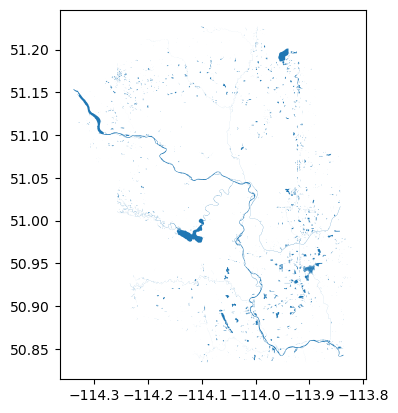

In [132]:
# https://data.calgary.ca/Environment/Hydrology/a2cn-dxht


hydrology_data = gpd.read_file("data/hydrology/Hydrology_20250501.csv")

hydrology_data["geometry"] = hydrology_data["MULTIPOLYGON"].apply(wkt.loads)
hydrology_data = hydrology_data.set_geometry("geometry")
hydrology_data = hydrology_data.set_crs(4326)
hydrology_data.plot()

In [133]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [220]:
time_range = "2020-06-01/2020-07-30"

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=boundary_bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 1}},
)
items = search.item_collection()

In [192]:
assets = [item.assets["lwir11"].href for item in items if "lwir11" in item.assets]
datetimes = [item.properties["datetime"] for item in items if "lwir11" in item.assets]
datetimes[:2]

['2020-07-26T18:30:03.778592Z', '2020-07-26T18:29:39.900262Z']

In [213]:
assets_to_merge = []
for asset in assets[:2]:
    with rasterio.open(asset) as src_dataset:
        dst_crs = src_dataset.crs
        if dst_crs == "EPSG:32612":
            assets_to_merge.append(asset)

bbox_ = transform_bounds(boundary_data.crs, "EPSG:32612", *boundary_bbox)
lst, out_trans = merge(assets_to_merge, bbox_, method="max", nodata=0)
len(assets_to_merge)

1

## Find average temp across city boundary

In [221]:
meta = {
    "driver": "GTiff",
    "height": lst.shape[1],
    "width": lst.shape[2],
    "count": 1,
    "dtype": "uint16",
    "crs": "EPSG:32612",
    "transform": out_trans,
    "nodata": 0,
}

boundary_transformed = boundary_data.to_crs("EPSG:32612")

with MemoryFile() as memfile:
    with memfile.open(**meta) as dataset:
        dataset.write(lst)
        out_masked_boundary, out_boundary_transform = mask(
            dataset, boundary_transformed.geometry, crop=True, nodata=0
        )
        lst_corrected = (out_masked_boundary * 0.00341802) + 149 - 273.15
        lst_corrected[lst_corrected < 0] = 0
        with rasterio.open("output/lst_boundary_clipped.tif", "w", **meta_2) as dst:
            dst.write(lst_corrected.squeeze().astype(rasterio.uint16), 1)

In [223]:
# set zero values to nan
lst_corrected[lst_corrected == 0] = np.nan
avg_temp = np.nanmean(lst_corrected)
avg_temp

np.float64(31.748928858360525)

In [215]:
hydrology_transformed = hydrology_data.to_crs("EPSG:32612")

meta_2 = {
    "driver": "GTiff",
    "height": lst.shape[1],
    "width": lst.shape[2],
    "count": 1,
    "dtype": "uint16",
    "crs": "EPSG:32612",
    "transform": out_trans,
    "nodata": 0,
}

with MemoryFile() as memfile:
    with memfile.open(**meta_2) as dataset:
        dataset.write(lst)
        out_hydrology_boundary, out_hydrology_transform = mask(
            dataset, hydrology_transformed.geometry, nodata=0, invert=True
        )
        lst_corrected = (out_hydrology_boundary * 0.00341802) + 149 - 273.15
        lst_corrected[lst_corrected < 0] = 0
        with rasterio.open("output/lst.tif", "w", **meta_2) as dst:
            dst.write(lst_corrected.squeeze().astype(rasterio.uint16), 1)

(array([3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        1.0000e+00, 5.0000e+00, 2.3300e+02, 1.2890e+03, 4.4040e+03,
        1.0381e+04, 1.7403e+04, 2.7789e+04, 4.3238e+04, 6.2722e+04,
        7.7547e+04, 8.3400e+04, 8.7313e+04, 8.5776e+04, 7.8654e+04,
        7.7320e+04, 7.7791e+04, 7.7519e+04, 7.6866e+04, 7.6727e+04,
        7.7070e+04, 7.4376e+04, 7.0618e+04, 6.4535e+04, 5.9606e+04,
        5.8122e+04, 5.7739e+04, 4.6756e+04, 3.0423e+04, 1.6288e+04,
        7.0620e+03, 2.9990e+03, 1.5840e+03, 8.3800e+02, 4.4300e+02,
        2.9500e+02, 1.6600e+02, 1.0100e+02, 8.5000e+01, 4.6000e+01,
        2.5000e+01, 2.0000e+01, 1.4000e+01, 6.0000e+00, 4.0000e+00]),
 array([10.17476798, 11.02913626, 11.88350454, 12.73787282, 13.5922411 ,
        14.44660938, 15.30097766, 16.15534593, 17.00971421, 17.86408249,
        18.71845077, 19.57281905, 20.42718733, 21.28155561, 22.13592389,
        22.99029217, 23.84466045, 24.69902873, 25.55339701, 26.40776528,
        27.26213356, 28.11

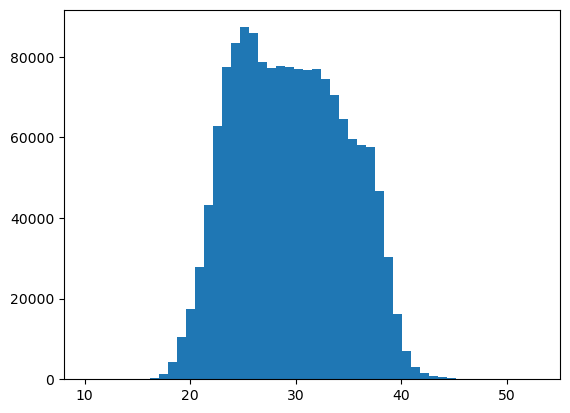

In [216]:
lst_corrected[lst_corrected == 0] = np.nan
plt.hist(lst_corrected.ravel(), bins=50)

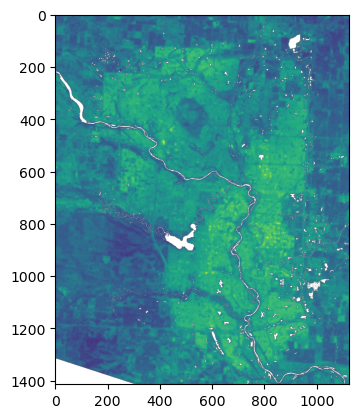

In [218]:
plt.imshow(lst_corrected.squeeze())

## Dissemination Area Boundaries

In [224]:
DA = gpd.read_file("data/DisseminationArea/lda_000b21a_e.shp")

In [225]:
census_data = pd.read_csv("output/DA_Calgary_census_data.csv")
df = DA.merge(census_data, left_on="DGUID", right_on="REF_AREA")[["DGUID", "geometry"]]

In [226]:
df = df.to_crs("EPSG:32612")
df.head()

,DGUID,geometry
0,2021S051248060056,"POLYGON ((283181.659 5669916.204, 283245.036 5..."
1,2021S051248060057,"POLYGON ((283700.486 5669966.112, 283702.041 5..."
2,2021S051248060058,"POLYGON ((283205.945 5669575.068, 283242.725 5..."
3,2021S051248060059,"POLYGON ((283896.638 5669972.142, 283963.332 5..."
4,2021S051248060060,"POLYGON ((283928.717 5670072.441, 283985.85 56..."


In [227]:
def calc_lst_da(x):
    with rasterio.open("output/lst.tif") as src:
        out_image, out_transform = rasterio.mask.mask(
            src, [x.geometry], crop=True, nodata=0
        )
        out_image_ = out_image[out_image != 0]
        return np.mean(out_image_)

In [228]:
# test_df = df[:10].copy()

In [233]:
df["lst"] = df.apply(calc_lst_da, axis=1)
df["avg_lst"] = avg_temp
df["temp_diff"] = df["lst"] - df["avg_lst"]

In [234]:
df.head()

,DGUID,geometry,lst,avg_lst,temp_diff
0,2021S051248060056,"POLYGON ((283181.659 5669916.204, 283245.036 5...",35.783582,31.748929,4.034653
1,2021S051248060057,"POLYGON ((283700.486 5669966.112, 283702.041 5...",35.680412,31.748929,3.931484
2,2021S051248060058,"POLYGON ((283205.945 5669575.068, 283242.725 5...",33.295455,31.748929,1.546526
3,2021S051248060059,"POLYGON ((283896.638 5669972.142, 283963.332 5...",34.093750,31.748929,2.344821
4,2021S051248060060,"POLYGON ((283928.717 5670072.441, 283985.85 56...",32.717314,31.748929,0.968386


In [235]:
df.to_file("output/lst.json")